# SOC Analysis

Comparing Coulomb counting and voltage interpolation methods.

In [1]:
from data_analysis.data_tools.time_series import TimeSeries
from data_analysis.data_tools.influx_client import InfluxClient
from data_analysis.soc import get_soc_from_voltage, get_soc_from_coulomb_counting

import matplotlib.pyplot as plt
import numpy as np

from scipy import signal

# 1st Run
start = "2024-07-16T15:00:00Z"
stop = "2024-07-17T02:34:12Z"

client = InfluxClient()

In [2]:
pack_voltage: TimeSeries = client.query_time_series(start, stop, "TotalPackVoltage", units="V")
pack_current: TimeSeries = client.query_time_series(start, stop, "PackCurrent", units="A")
pack_current, pack_voltage = TimeSeries.align(pack_current, pack_voltage)

/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "car": query_df["car"][0],
/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "measurement": query_df["_measurement"][0],
/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

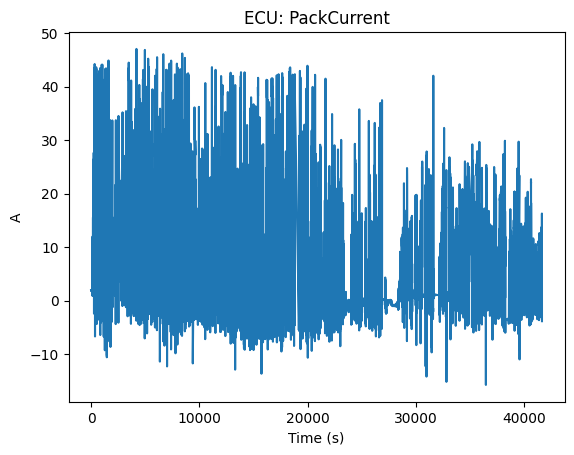

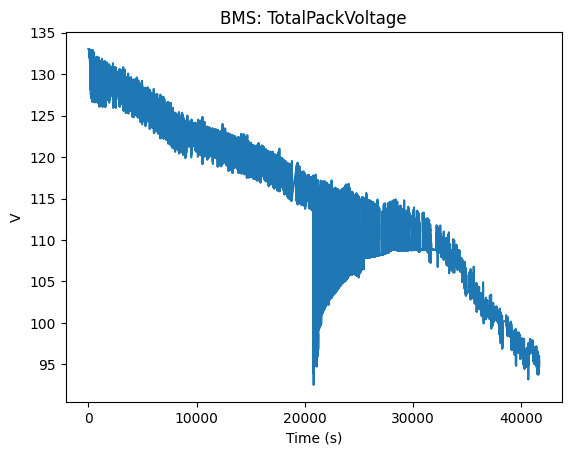

In [3]:
pack_current_filtered = pack_current.promote(signal.savgol_filter(pack_current, 100, 3))
pack_current_filtered.plot()

pack_voltage.plot()

## Voltage Interpolation

Let's try to estimate SOC with voltage interpolation first.

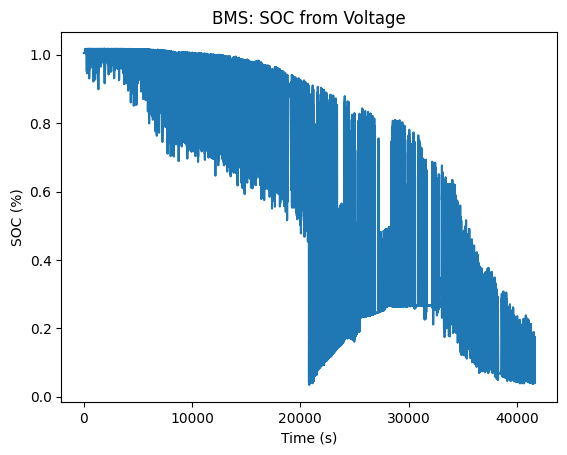

In [4]:
soc_voltage = pack_voltage.promote(get_soc_from_voltage(pack_voltage, pack_current))
soc_voltage.meta["field"] = "SOC from Voltage"
soc_voltage.units = "SOC (%)"
soc_voltage.plot()

In [5]:
print(f"Initial SOC: {soc_voltage[0]}")
print(f"Final SOC: {soc_voltage[-1]}")
print(f"Change in SOC: {soc_voltage[0] - soc_voltage[-1]}")

Initial SOC: 1.0050566501950555
Final SOC: 0.040767810012374735
Change in SOC: 0.9642888401826808


In [6]:
np.trapz(pack_current) / 3600 / 1378

TimeSeries(0.55737453)

## Coulomb Counting

Now, let's look at Coulomb counting, using the initial SOC found with the previous method as our initial SOC.

In [10]:
soc_coulomb_counting, _, _ = get_soc_from_coulomb_counting(0.99, np.full_like(pack_current_filtered, fill_value=100), -pack_current_filtered, 0.25)

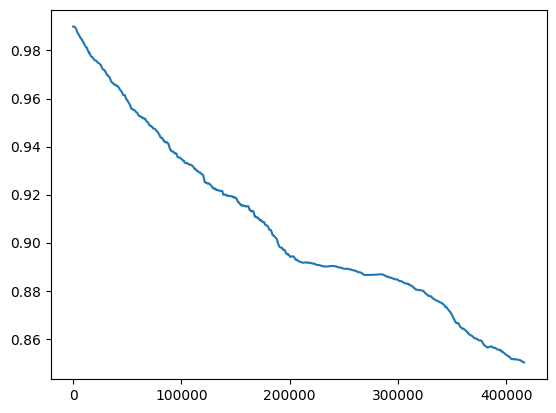

In [11]:
plt.plot(soc_coulomb_counting)

In [9]:
print(f"Initial SOC: {soc_coulomb_counting[0]}")
print(f"Final SOC: {soc_coulomb_counting[-1]}")
print(f"Change in SOC: {soc_coulomb_counting[0] - soc_coulomb_counting[-1]}")

Initial SOC: 0.99
Final SOC: 0.8501285343014982
Change in SOC: 0.13987146569850184


## Results

In [ ]:
fig, ax = plt.subplots()

ax.plot(soc_coulomb_counting.x_axis, soc_coulomb_counting, label="Coulomb Counting")
ax.plot(soc_voltage.x_axis, soc_voltage, label="Voltage Interpolation")

ax.set_xlabel("Time (s)")
ax.set_ylabel("SOC (%)")
ax.set_title("SOC, estimated with two different methods")

plt.legend()
plt.show()